In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TactileDriven_Arto/UTILITIES')

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils   import class_weight

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model


data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Levers_Knobs/DATA/1D_TRANSF_KNOB_FTP_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

X_data = X_data[:, :, 4]

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000
N_CLASS = 6
DISP_LABELS = ["0", "1", "2", "3", "4", "5"]

2024-10-29 23:33:06.738658: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 23:33:06.767176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 23:33:07.181506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (629, 2000)
y_data shape: (629,)
X_data.[0] shape:  (2000,)
TOTAL DATA: 629  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (377, 2000)    ||  Dimensions of y_train: (377,)
Dimensions of X_test:  (126, 2000)    ||  Dimensions of y_test:  (126,)
Dimensions of X_val:   (126, 2000)    ||  Dimensions of y_val:   (126,)


2024-10-29 23:33:07.524192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:33:07.524355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:33:07.551998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 1 CONVs

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-29 23:33:07.833055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:33:07.833208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentatio

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 496, 512)       │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 248, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 126976)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,126,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,137,670 (31.04 MB)

 Trainable params: 8,137,670 (31.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22


I0000 00:00:1730241188.658668 2023669 service.cc:145] XLA service 0x7f8ff80049a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730241188.658688 2023669 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1730241188.658690 2023669 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-10-29 23:33:08.669872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 23:33:08.719602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/12 ━━━━━━━━━━━━━━━━━━━━ 10s 930ms/step - accuracy: 0.1250 - loss: 1.7576

I0000 00:00:1730241189.257730 2023669 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2418 - loss: 1.9538 - val_accuracy: 0.3492 - val_loss: 1.5824
Epoch 2/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4679 - loss: 1.3204 - val_accuracy: 0.6349 - val_loss: 1.1368
Epoch 3/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 0.9566 - val_accuracy: 0.5397 - val_loss: 1.1489
Epoch 4/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5968 - loss: 0.8754 - val_accuracy: 0.6349 - val_loss: 0.9214
Epoch 5/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 0.7645 - val_accuracy: 0.7302 - val_loss: 0.7842
Epoch 6/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7706 - loss: 0.6380 - val_accuracy: 0.5794 - val_loss: 1.1283
Epoch 7/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7600 - loss: 0.6879 - val_accuracy: 0.7381 - val_loss: 0.8728
Epoch 8/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7770 - loss: 0.5821 - val_accuracy: 0.7698 - val_loss: 0.6850
Ep

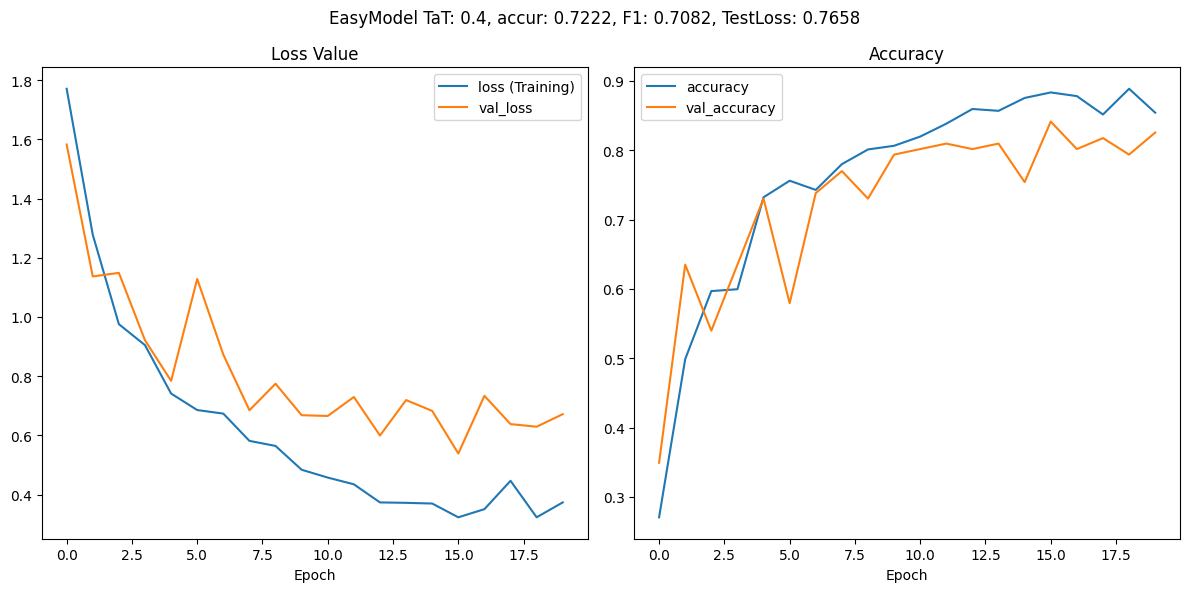

Train loss: 0.3738023638725281
Test val_loss: 0.671837568283081
Train accuracy: 0.8541114330291748
Accuracy Score: 0.7222222222222222
F1 Score: 0.7081941519950895
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.86      0.84        21
         1.0       0.82      0.79      0.81        39
         2.0       0.55      0.52      0.54        21
         3.0       0.88      0.64      0.74        11
         4.0       0.65      0.81      0.72        16
         5.0       0.61      0.61      0.61        18

    accuracy                           0.72       126
   macro avg       0.72      0.71      0.71       126
weighted avg       0.73      0.72      0.72       126



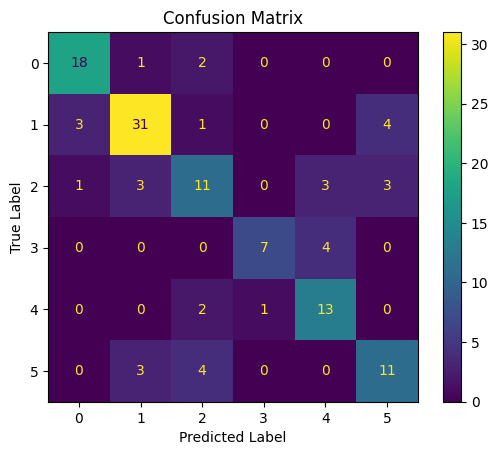

In [2]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=20, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=22, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights,verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels, zero_division=0))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 197, 512)       │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 194, 128)       │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,910 (1.11 MB)

 Trainable params: 291,910 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1304 - loss: 1.8451 - val_accuracy: 0.2222 - val_loss: 1.8218
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2159 - loss: 1.7521 - val_accuracy: 0.2698 - val_loss: 1.6723
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2543 - loss: 1.7070 - val_accuracy: 0.2540 - val_loss: 1.5941
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2838 - loss: 1.6454 - val_accuracy: 0.3968 - val_loss: 1.4907
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3684 - loss: 1.5188 - val_accuracy: 0.4603 - val_loss: 1.4154
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3890 - loss: 1.4546 - val_accuracy: 0.3571 - val_loss: 1.3980
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3930 - loss: 1.4090 - val_accuracy: 0.3571 - val_loss: 1.3116
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3776 - loss: 1.3772 - val_accuracy: 0.5317 - val_loss: 1.1965
Ep

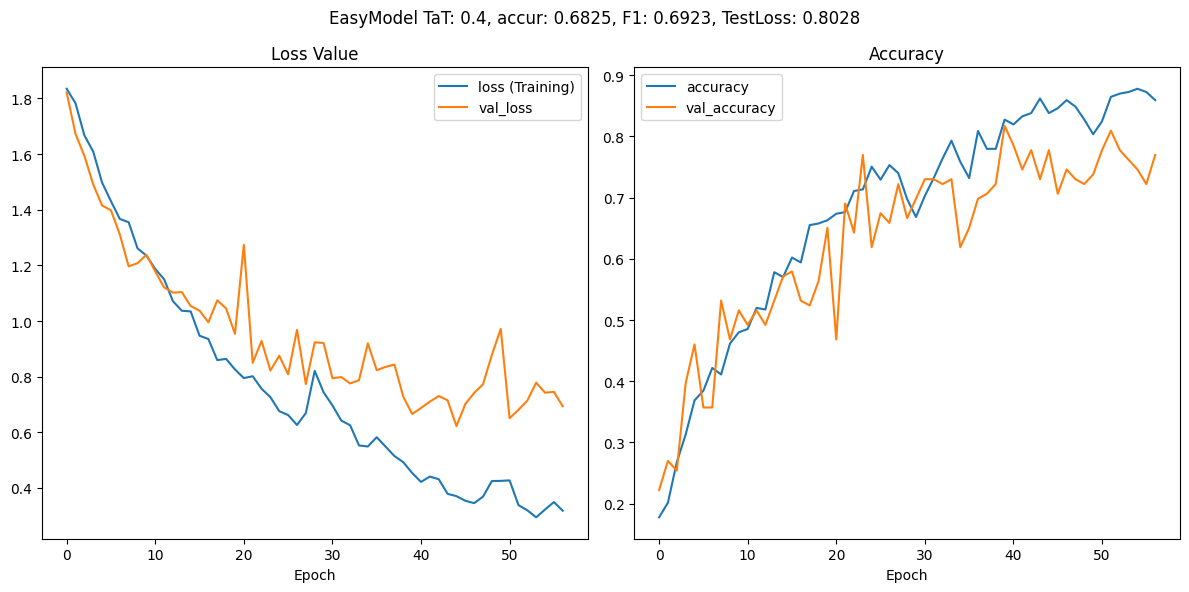

Train loss: 0.3183380961418152
Test val_loss: 0.6935436129570007
Train accuracy: 0.8594164252281189
Accuracy Score: 0.6825396825396826
F1 Score: 0.6923434721307061
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.95      0.85        21
         1.0       0.71      0.56      0.63        39
         2.0       0.57      0.62      0.59        21
         3.0       0.67      0.91      0.77        11
         4.0       0.86      0.75      0.80        16
         5.0       0.53      0.50      0.51        18

    accuracy                           0.68       126
   macro avg       0.68      0.72      0.69       126
weighted avg       0.68      0.68      0.68       126



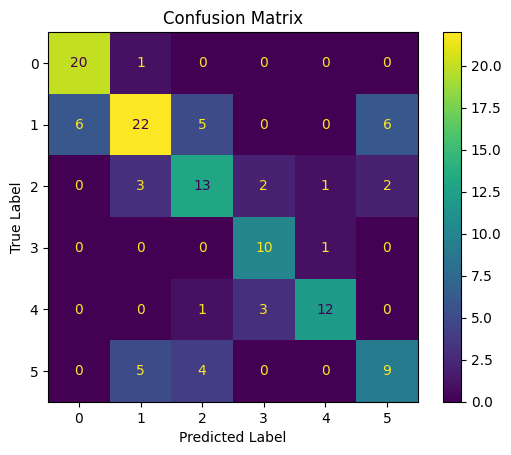

In [3]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=40, strides=10, activation='relu', input_shape=(WS_B, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights,verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels, zero_division=.000))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2 CONV with K-Fold to reduce problems about unbalaced Data. BAD PErformances

In [4]:
# import numpy as np
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.utils import class_weight
# from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
# from sklearn.model_selection import StratifiedKFold
# import matplotlib.pyplot as plt
# import os

# # Assuming WS_B is the input length for your model (e.g., 2000)
# WS_B = 2000

# # Define the model
# def build_easyModel():
#     model = Sequential()
#     model.add(Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', input_shape=(WS_B, 1)))
#     model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(N_CLASS, activation='softmax'))
#     return model


# X, y = X_data, y_data

# # Prepare for k-fold cross-validation
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold_no = 1
# results = []

# for train_index, test_index in kfold.split(X, y):
#     print(f'Training fold {fold_no}...')
    
#     # Split data
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # Calculate class weights
#     class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#     class_weights = {i: class_weights[i] for i in range(len(class_weights))}

#     # Build and compile the model
#     model = build_easyModel()
#     model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
#     history = model.fit(X_train, y_train, epochs=22, batch_size=32, validation_split=0.2, class_weight=class_weights, verbose=1, callbacks=[early_stopping])

#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test)

#     # Predict labels for test data
#     y_pred = model.predict(X_test)
#     y_pred_labels = np.argmax(y_pred, axis=1)

#     f1 = f1_score(y_test, y_pred_labels, average='macro')
#     accuracy = accuracy_score(y_test, y_pred_labels)

#     print(f'Fold {fold_no} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
    
#     results.append((loss, accuracy, f1))

#     # Plot the results for this fold
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Plot Loss Value
#     axs[0].plot(history.history["loss"], label="loss (Training)")
#     axs[0].plot(history.history["val_loss"], label="val_loss")
#     axs[0].set_title(f"Loss Value (Fold {fold_no})")
#     axs[0].set_xlabel('Epoch')
#     axs[0].legend()

#     # Plot Accuracy
#     axs[1].plot(history.history["accuracy"], label="accuracy")
#     axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
#     axs[1].set_title(f"Accuracy (Fold {fold_no})")
#     axs[1].set_xlabel('Epoch')
#     axs[1].legend()

#     plt.suptitle(f"Fold {fold_no}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Test Loss: {loss:.4f}")
#     plt.tight_layout()
#     plt.show()

#     # Print evaluation metrics for this fold
#     print(f"Fold {fold_no} Train loss:", history.history["loss"][-1])
#     print(f"Fold {fold_no} Test val_loss:", history.history["val_loss"][-1])
#     print(f"Fold {fold_no} Train accuracy:", history.history["accuracy"][-1])
#     print(f"Fold {fold_no} Accuracy Score:", accuracy)
#     print(f"Fold {fold_no} F1 Score:", f1)
#     print(f"Fold {fold_no} Classification Report:\n", classification_report(y_test, y_pred_labels, zero_division=0))

#     # Plot the confusion matrix for this fold
#     conf_mat = confusion_matrix(y_test, y_pred_labels)
#     disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix (Fold {fold_no})')
#     plt.show()

#     fold_no += 1

# # Calculate average results
# average_loss = np.mean([result[0] for result in results])
# average_accuracy = np.mean([result[1] for result in results])
# average_f1 = np.mean([result[2] for result in results])

# print(f'Average Loss: {average_loss:.4f}')
# print(f'Average Accuracy: {average_accuracy:.4f}')
# print(f'Average F1 Score: {average_f1:.4f}')


# 3 CONVs

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 498, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 123, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 122, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,062 (519.77 KB)

 Trainable params: 133,062 (519.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.2330 - loss: 1.7333 - val_accuracy: 0.3095 - val_loss: 1.6732
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3045 - loss: 1.6794 - val_accuracy: 0.4524 - val_loss: 1.6315
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3295 - loss: 1.6187 - val_accuracy: 0.4524 - val_loss: 1.5466
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3790 - loss: 1.5269 - val_accuracy: 0.3730 - val_loss: 1.4767
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4034 - loss: 1.4723 - val_accuracy: 0.3730 - val_loss: 1.4385
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4043 - loss: 1.4226 - val_accuracy: 0.4524 - val_loss: 1.3712
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4398 - loss: 1.3750 - val_accuracy: 0.4365 - val_loss: 1.3344
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4500 - loss: 1.2973 - val_accuracy: 0.4841 -

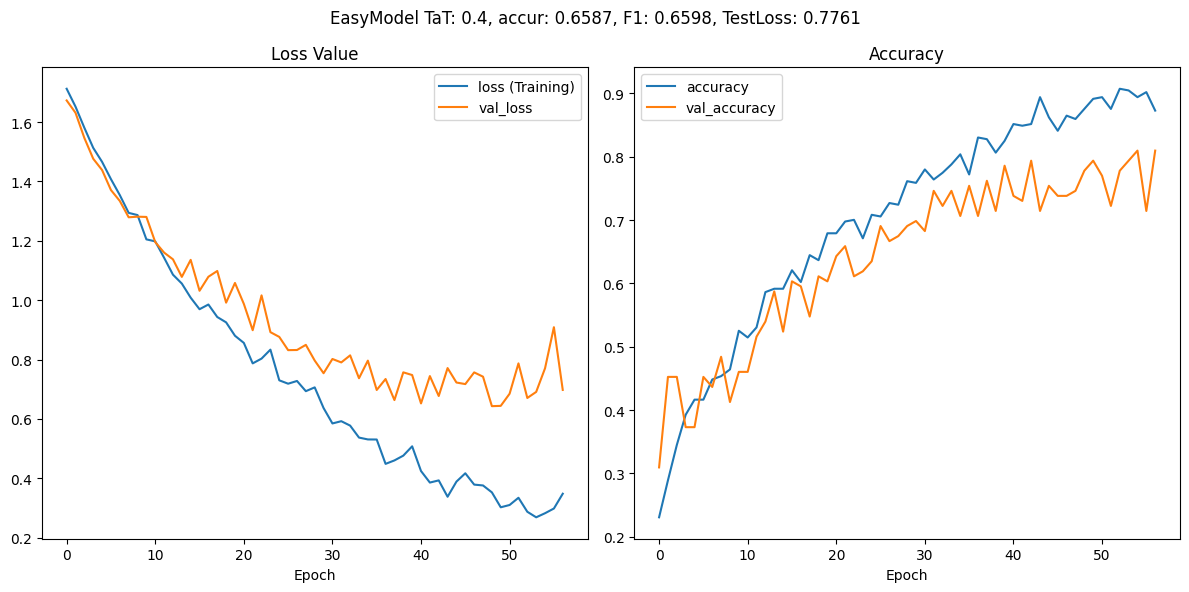

Train loss: 0.34760504961013794
Test val_loss: 0.6974719166755676
Train accuracy: 0.8726790547370911
Accuracy Score: 0.6587301587301587
F1 Score: 0.6598201915103323
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.86      0.82        21
         1.0       0.69      0.56      0.62        39
         2.0       0.73      0.52      0.61        21
         3.0       0.56      0.82      0.67        11
         4.0       0.62      0.81      0.70        16
         5.0       0.53      0.56      0.54        18

    accuracy                           0.66       126
   macro avg       0.65      0.69      0.66       126
weighted avg       0.67      0.66      0.65       126



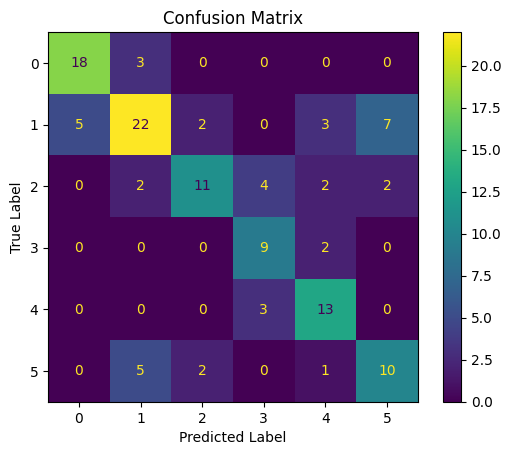

In [5]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=10, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=4, strides=2, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_CLASS, activation='softmax'))

    return model
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4 CONVs or Still "COMPLEX"

/home/rl_sim/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 996, 256)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 498, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 248, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 248, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 120, 128)       │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 57, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,406 (2.40 MB)

 Trainable params: 630,406 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.2341 - loss: 1.7471 - val_accuracy: 0.2540 - val_loss: 1.7022
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2645 - loss: 1.6972 - val_accuracy: 0.2778 - val_loss: 1.6921
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3708 - loss: 1.6198 - val_accuracy: 0.3810 - val_loss: 1.6103
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3330 - loss: 1.5577 - val_accuracy: 0.3413 - val_loss: 1.5077
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3962 - loss: 1.4286 - val_accuracy: 0.4286 - val_loss: 1.3949
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4868 - loss: 1.2932 - val_accuracy: 0.4921 - val_loss: 1.2909
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4887 - loss: 1.2382 - val_accuracy: 0.5794 - val_loss: 1.1866
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5599 - loss: 1.1257 - val_accuracy: 0.4127 - val_loss: 1.3107
E

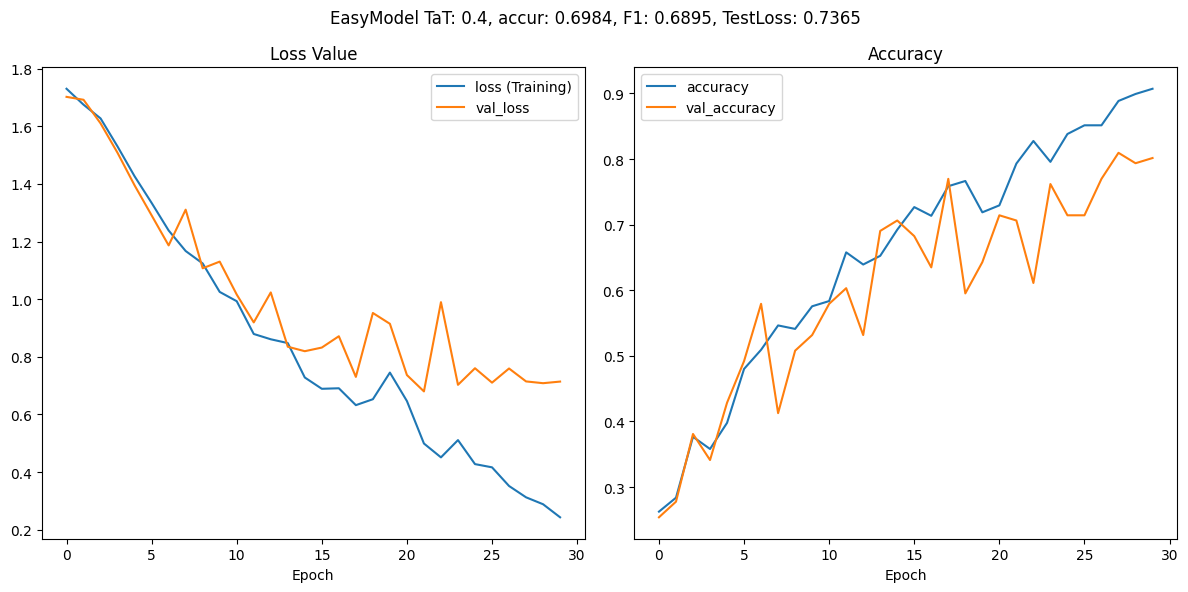

Train loss: 0.24284228682518005
Test val_loss: 0.7139327526092529
Train accuracy: 0.9071618318557739
Accuracy Score: 0.6984126984126984
F1 Score: 0.6895104169613973
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        21
         1.0       0.76      0.74      0.75        39
         2.0       0.58      0.67      0.62        21
         3.0       0.62      0.91      0.74        11
         4.0       0.91      0.62      0.74        16
         5.0       0.50      0.44      0.47        18

    accuracy                           0.70       126
   macro avg       0.70      0.70      0.69       126
weighted avg       0.71      0.70      0.70       126



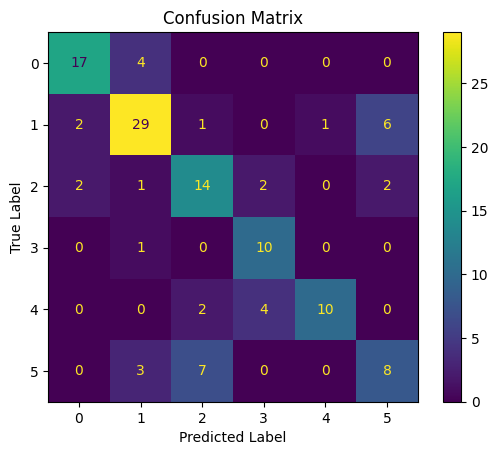

: 

In [6]:
def build_easyModel():
    model = Sequential()
    
    model.add(Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=256, kernel_size=4, strides=2, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(filters=128, kernel_size=10, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 CONVS